<a href="https://colab.research.google.com/github/Gelasemi/Amazon-Recommender-System/blob/main/Creditcard_Fraude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Pour traiter le sujet d'examen sur la détection de fraudes par réseau de neurones, je vais vous fournir une suggestion détaillée des moyens et étapes pour aborder ce problème, ainsi qu’un script Python complet, étape par étape, pour construire un modèle de classification binaire. Le script utilisera un dataset typique de détection de fraudes (comme celui de Kaggle sur les transactions par carte de crédit) et inclura la gestion du déséquilibre des classes, l’entraînement d’un réseau de neurones, et l’évaluation des performances avec un F1-score > 0.90. Je vais également structurer un rapport explicatif dans le livrable.
#1. Suggestion de moyens et étapes
#Moyens :Langage et bibliothèques : Python avec TensorFlow/Keras pour le réseau de neurones, scikit-learn pour le prétraitement et les métriques, pandas et numpy pour la manipulation des données, et imbalanced-learn pour gérer le déséquilibre des classes.
#Dataset : Utilisation du dataset Kaggle "Credit Card Fraud Detection" (https://www.kaggle.com/mlg-ulb/creditcardfraud), qui contient des transactions anonymisées avec une classe cible binaire (0 : non-frauduleuse, 1 : frauduleuse).Creditcard_2023.CSV
#Outils : Jupyter Notebook ou Google Colab pour exécuter le script, avec matplotlib/seaborn pour visualiser les résultats.
#Environnement : Compatible avec un ordinateur personnel ou une plateforme cloud (Colab avec GPU pour accélérer l’entraînement).

In [ ]:
#2-Étapes générales :

  #  Exploration et préparation des données :
   #     Charger le dataset et explorer la distribution des classes.
    #    Gérer les valeurs manquantes et normaliser les caractéristiques (les données sont souvent déjà transformées par PCA dans ce dataset).
     #   Diviser les données en ensembles d’entraînement, de validation et de test.

In [ ]:
#Les librairies

In [1]:
import subprocess
import sys

def run(cmd):
    print(f"\n> {cmd}")
    subprocess.check_call([sys.executable, "-m", "pip"] + cmd.split())

# Étapes de nettoyage
print("=== Désinstallation des paquets existants ===")
run("uninstall -y tensorflow keras uvicorn")

# Installation de TensorFlow 2.19.0 (inclut keras 2.19.0 automatiquement)
print("\n=== Installation de tensorflow==2.19.0 ===")
run("install tensorflow==2.19.0")

# Réinstallation d'uvicorn
print("\n=== Réinstallation de uvicorn ===")
run("install uvicorn")

print("\n✅ Installation terminée avec succès.")

=== Désinstallation des paquets existants ===

> uninstall -y tensorflow keras uvicorn

=== Installation de tensorflow==2.19.0 ===

> install tensorflow==2.19.0

=== Réinstallation de uvicorn ===

> install uvicorn

✅ Installation terminée avec succès.


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
!pip install gdown
import gdown

gdown.download("https://drive.google.com/uc?id=1bPO3lk56RK7Rf7a4PiysdnEuKe9cUomz", "creditcard_2023.csv", quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1bPO3lk56RK7Rf7a4PiysdnEuKe9cUomz
From (redirected): https://drive.google.com/uc?id=1bPO3lk56RK7Rf7a4PiysdnEuKe9cUomz&confirm=t&uuid=fb3f27cf-4128-4111-9967-28223a88d3e9
To: /content/creditcard_2023.csv
100%|██████████| 325M/325M [00:05<00:00, 55.9MB/s]


'creditcard_2023.csv'

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import gzip
import shutil
#for file in ['xgb_fraud_model.pkl', 'scaler.pkl']:
 #   with gzip.open(f'{file}.gz', 'rb') as f_in:
  #      with open(file, 'wb') as f_out:
   #         shutil.copyfileobj(f_in, f_out)

In [9]:
# Étape 1 : Charger les librairies
import pandas as pd
import os

# Le fichier a été téléchargé dans /content via gdown
file_path = "/content/creditcard_2023.csv"

# Vérification de l'existence du fichier
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Le fichier {file_path} n'existe pas. Vérifiez le chemin.")

# Chargement des données
data = pd.read_csv(file_path)

# Aperçu des données
print("✅ Dataset chargé avec succès")
print("Dimensions du dataset :", data.shape)
print("Distribution des classes :\n", data['Class'].value_counts(normalize=True))


✅ Dataset chargé avec succès
Dimensions du dataset : (568630, 31)
Distribution des classes :
 Class
0    0.5
1    0.5
Name: proportion, dtype: float64


Downloading...
From (original): https://drive.google.com/uc?id=1bPO3lk56RK7Rf7a4PiysdnEuKe9cUomz
From (redirected): https://drive.google.com/uc?id=1bPO3lk56RK7Rf7a4PiysdnEuKe9cUomz&confirm=t&uuid=af0f3814-579b-4047-91c5-223953e6bf3a
To: /content/creditcard_2023.csv
100%|██████████| 325M/325M [00:05<00:00, 64.0MB/s]


✅ Données chargées : creditcard_2023.csv
Dimensions : (568630, 31)

Aperçu des premières lignes :
   id     V1     V2    V3     V4    V5    V6    V7     V8     V9  ...    V21  \
0   0 -0.261 -0.470 2.496 -0.084 0.130 0.733 0.519 -0.130  0.727  ... -0.111   
1   1  0.985 -0.356 0.558 -0.430 0.277 0.429 0.406 -0.133  0.347  ... -0.195   
2   2 -0.260 -0.949 1.729 -0.458 0.074 1.419 0.744 -0.096 -0.261  ... -0.005   
3   3 -0.152 -0.509 1.747 -1.090 0.249 1.143 0.518 -0.065 -0.206  ... -0.147   
4   4 -0.207 -0.165 1.527 -0.448 0.106 0.531 0.659 -0.213  1.050  ... -0.107   

     V22    V23    V24    V25    V26    V27    V28    Amount  Class  
0  0.218 -0.135  0.166  0.126 -0.435 -0.081 -0.151 17982.100      0  
1 -0.606  0.079 -0.577  0.190  0.297 -0.248 -0.065  6531.370      0  
2  0.703  0.945 -1.155 -0.606 -0.313 -0.300 -0.245  2513.540      0  
3 -0.038 -0.214 -1.893  1.004 -0.516 -0.165  0.048  5384.440      0  
4  0.730 -0.162  0.313 -0.414  1.071  0.024  0.419 14278.970      0  



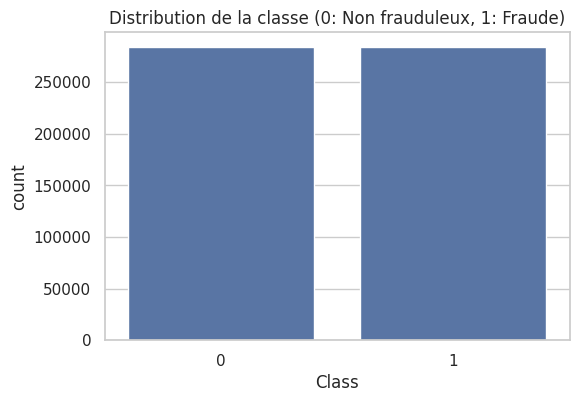

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


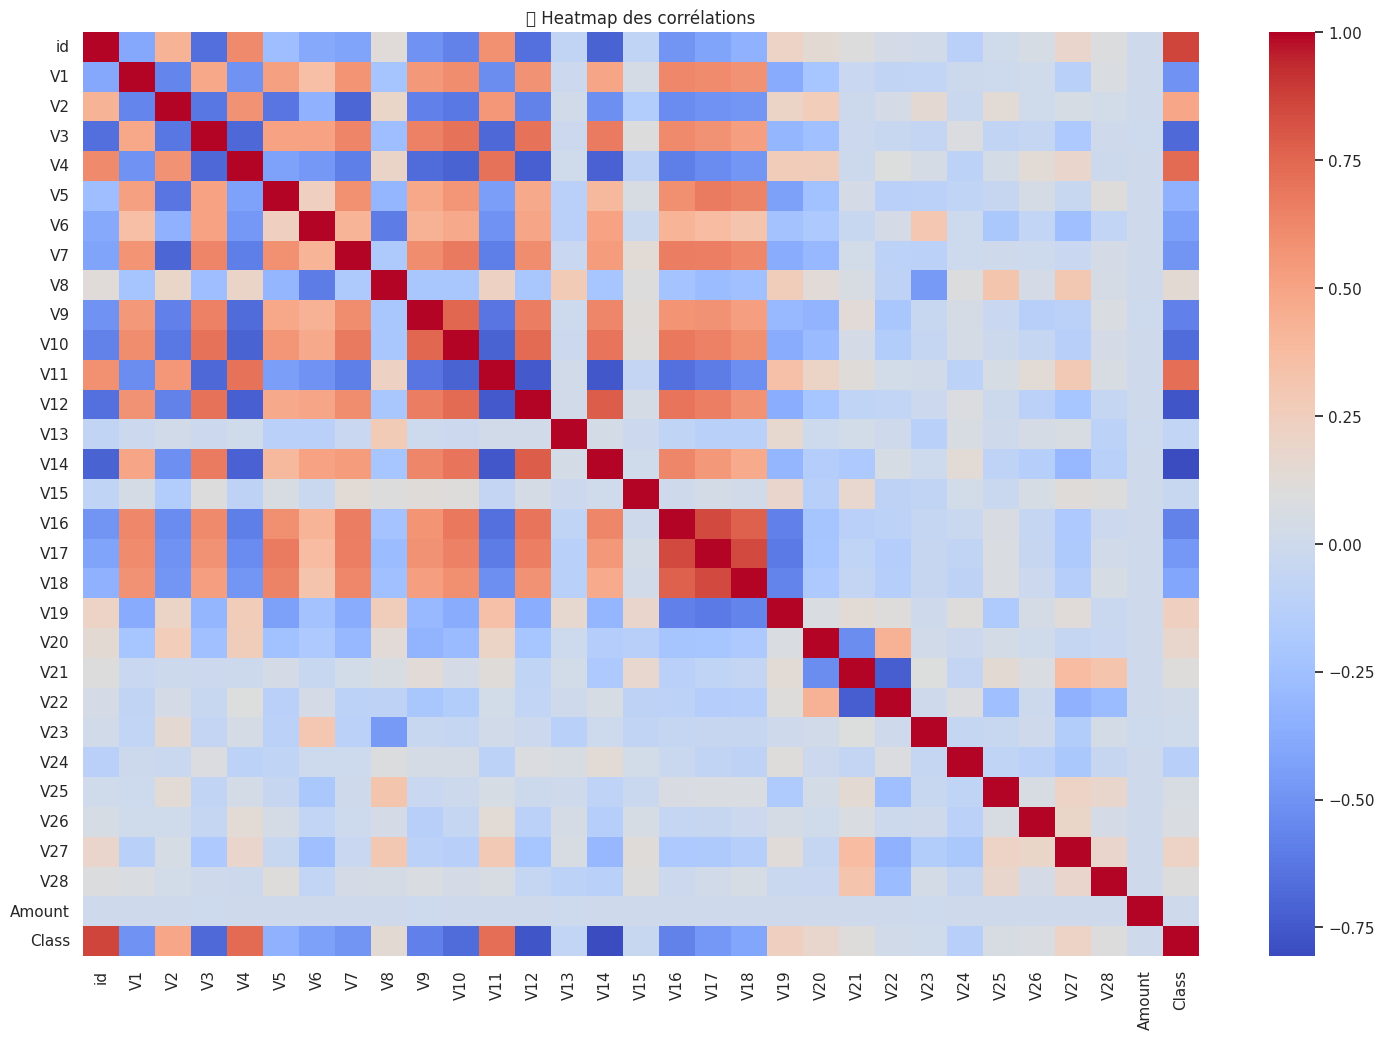

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


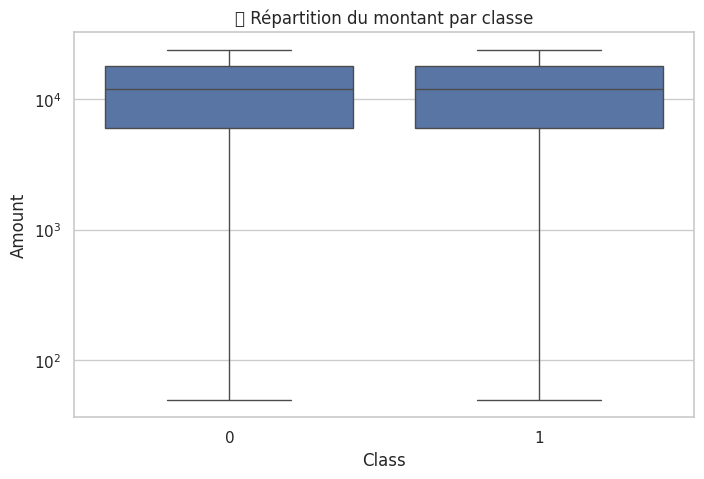

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


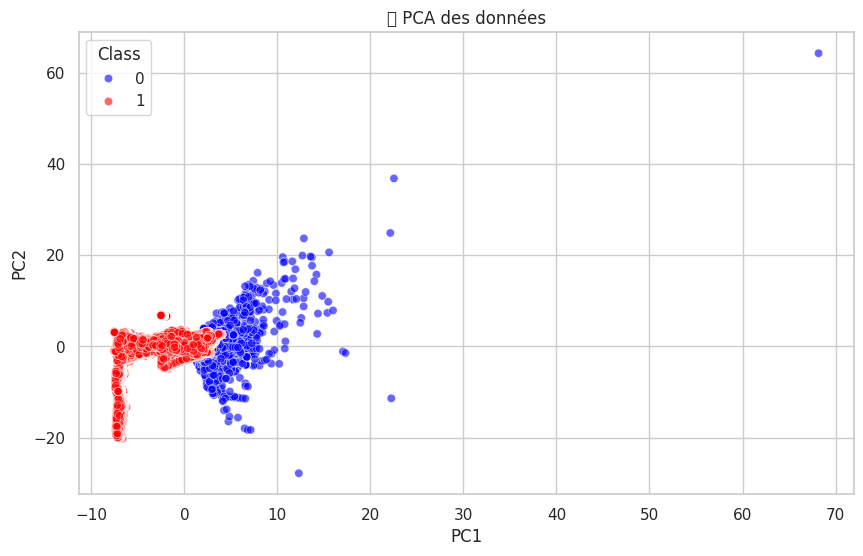


📈 Indicateurs de performance :
Total des transactions : 568630
Nombre de fraudes : 284315 (50.00%)
Moyenne montant - Fraude : 12057.60
Moyenne montant - Non-Fraude : 12026.31
Montant total en fraude : 3428157045.35 €
Montant total (toutes transactions) : 6847418369.75 €


In [1]:
# Étape 1 : Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Configuration des affichages
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set(style="whitegrid")

# Étape 2 : Télécharger le fichier depuis Google Drive
file_url = "https://drive.google.com/uc?id=1bPO3lk56RK7Rf7a4PiysdnEuKe9cUomz"
output_path = "creditcard_2023.csv"
gdown.download(file_url, output_path, quiet=False)

# Charger les données
data = pd.read_csv(output_path)
print("✅ Données chargées :", output_path)
print("Dimensions :", data.shape)
print("\nAperçu des premières lignes :")
print(data.head())

# Étape 3 : Analyse des valeurs manquantes
print("\n📌 Valeurs manquantes par colonne :")
print(data.isnull().sum())

# Étape 4 : Statistiques descriptives
print("\n📊 Statistiques descriptives :")
print(data.describe())

# Étape 5 : Distribution de la variable cible (fraude ou non)
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=data)
plt.title("Distribution de la classe (0: Non frauduleux, 1: Fraude)")
plt.show()

# Étape 6 : Analyse des corrélations entre variables
plt.figure(figsize=(18, 12))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title("🔥 Heatmap des corrélations")
plt.show()

# Étape 7 : Boxplots pour visualiser la distribution des montants
plt.figure(figsize=(8,5))
sns.boxplot(x='Class', y='Amount', data=data)
plt.title("💸 Répartition du montant par classe")
plt.yscale('log')  # Log scale pour limiter les valeurs extrêmes
plt.show()

# Étape 8 : Distribution temporelle des fraudes
if 'Time' in data.columns:
    data['Time_hours'] = data['Time'] / 3600
    plt.figure(figsize=(10, 4))
    sns.histplot(data[data['Class'] == 1]['Time_hours'], bins=100, color='red', label='Fraude', alpha=0.6)
    sns.histplot(data[data['Class'] == 0]['Time_hours'], bins=100, color='green', label='Non-fraude', alpha=0.4)
    plt.legend()
    plt.title("⏱️ Répartition temporelle des transactions")
    plt.xlabel("Heures depuis le début")
    plt.show()

# Étape 9 : PCA pour réduction de dimension
features = data.drop(columns=['Class', 'Time'], errors='ignore')
scaler = StandardScaler()
scaled = scaler.fit_transform(features)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled)

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['Class'] = data['Class']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Class', data=pca_df, palette={0: 'blue', 1: 'red'}, alpha=0.6)
plt.title("🧬 PCA des données")
plt.show()

# Étape 10 : KPIs style DAX
print("\n📈 Indicateurs de performance :")
total_transactions = data.shape[0]
fraude = data[data['Class'] == 1]
non_fraude = data[data['Class'] == 0]

print(f"Total des transactions : {total_transactions}")
print(f"Nombre de fraudes : {len(fraude)} ({100*len(fraude)/total_transactions:.2f}%)")
print(f"Moyenne montant - Fraude : {fraude['Amount'].mean():.2f}")
print(f"Moyenne montant - Non-Fraude : {non_fraude['Amount'].mean():.2f}")
print(f"Montant total en fraude : {fraude['Amount'].sum():.2f} €")
print(f"Montant total (toutes transactions) : {data['Amount'].sum():.2f} €")

# Étape 11 : Agrégations temporelles
if 'Time' in data.columns:
    data['hour'] = (data['Time'] // 3600).astype(int)
    hourly = data.groupby('hour').agg({
        'Amount': ['mean', 'sum'],
        'Class': ['sum', 'count']
    })
    hourly.columns = ['Avg_Amount', 'Total_Amount', 'Fraudes', 'Total_Transactions']
    hourly['Fraude_Rate'] = hourly['Fraudes'] / hourly['Total_Transactions']

    hourly.reset_index(inplace=True)

    plt.figure(figsize=(12,6))
    sns.lineplot(data=hourly, x='hour', y='Fraude_Rate', marker='o')
    plt.title("📊 Taux de fraude par heure")
    plt.xlabel("Heure")
    plt.ylabel("Taux de fraude")
    plt.grid(True)
    plt.show()


In [11]:
# Étape 2 : Prétraitement
print("\nÉtape 2 : Prétraitement")

# Séparation des variables explicatives et de la cible
X = data.drop('Class', axis=1)
y = data['Class']

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Division des données (60% train, 20% val, 20% test)
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.4, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Taille de l'ensemble d'entraînement :", X_train.shape)
print("Taille de l'ensemble de validation :", X_val.shape)
print("Taille de l'ensemble de test :", X_test.shape)



Étape 2 : Prétraitement
Taille de l'ensemble d'entraînement : (341178, 30)
Taille de l'ensemble de validation : (113726, 30)
Taille de l'ensemble de test : (113726, 30)


In [12]:
# Étape 3 : Gestion du déséquilibre des classes avec SMOTE
print("\nÉtape 3 : Gestion du déséquilibre des classes")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("Distribution des classes après SMOTE :\n", pd.Series(y_train_smote).value_counts(normalize=True))



Étape 3 : Gestion du déséquilibre des classes
Distribution des classes après SMOTE :
 Class
0    0.5
1    0.5
Name: proportion, dtype: float64


In [15]:
# Étape 4 : Définition des modèles
print("\nÉtape 4 : Définition des modèles")
# Réseau de neurones
def create_mlp(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Modèles à comparer
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'MLP': None  # Créé plus tard pour TensorFlow
}
# Création du MLP
input_shape = X_train.shape[1]
mlp_model = create_mlp(input_shape)
models['MLP'] = mlp_model


Étape 4 : Définition des modèles


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# Exemple d'entraînement du MLP (les autres modèles se font avec .fit())
print("\nEntraînement du MLP")
history = models['MLP'].fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=2048,
    verbose=1
)



Entraînement du MLP
Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8706 - loss: 0.3193 - val_accuracy: 0.9939 - val_loss: 0.0180
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9906 - loss: 0.0298 - val_accuracy: 0.9978 - val_loss: 0.0078
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9959 - loss: 0.0142 - val_accuracy: 0.9986 - val_loss: 0.0053
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9973 - loss: 0.0105 - val_accuracy: 0.9990 - val_loss: 0.0043
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9979 - loss: 0.0083 - val_accuracy: 0.9992 - val_loss: 0.0038
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9984 - loss: 0.0064 - val_accuracy: 0.9993 - val_loss: 0.0034
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9984 - loss: 0.0059 - val_accuracy: 0.9993 - val_loss: 0.0030
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9988 - lo

✅ Dataset chargé avec succès
Dimensions du dataset : (568630, 31)
Distribution des classes :
 Class
0    0.5
1    0.5
Name: proportion, dtype: float64
Dimensions des ensembles :
 - Entraînement : (341178, 29)
 - Validation : (113726, 29)
 - Test : (113726, 29)

🔹 Entraînement de Logistic Regression...

🔹 Entraînement de Random Forest...

🔹 Entraînement de XGBoost...

🔹 Entraînement du MLP...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8068 - loss: 0.4016 - val_accuracy: 0.9621 - val_loss: 0.0980
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9601 - loss: 0.1087 - val_accuracy: 0.9755 - val_loss: 0.0643
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9717 - loss: 0.0754 - val_accuracy: 0.9846 - val_loss: 0.0418
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9801 - loss: 0.0554 - val_accuracy: 0.9918 - val_loss: 0.0291
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9858 - loss: 0.0416 - val_accuracy: 0.9948 - val_loss: 0.0203
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9898 - loss: 0.0314 - val_accuracy: 0.9966 - val_loss: 0.0152
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9923 - loss: 0.0243 - val_accuracy: 0.9977 - val_loss: 0.0115
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9941 - loss: 0.0199 - val_accu


✅ Résultats comparatifs des modèles :

                 Model  Accuracy  F1-Score  Precision    Recall   AUC-ROC  \
0  Logistic Regression  0.963614  0.963121   0.976348  0.950249  0.993436   
1        Random Forest  0.999824  0.999824   0.999648  1.000000  1.000000   
2              XGBoost  0.999613  0.999613   0.999227  1.000000  0.999992   
3                  MLP  0.998329  0.998332   0.996670  1.000000  0.999808   

       RMSE        R²  
0  0.163018  0.893701  
1  0.019989  0.998402  
2  0.017812  0.998731  
3  0.037151  0.994479  


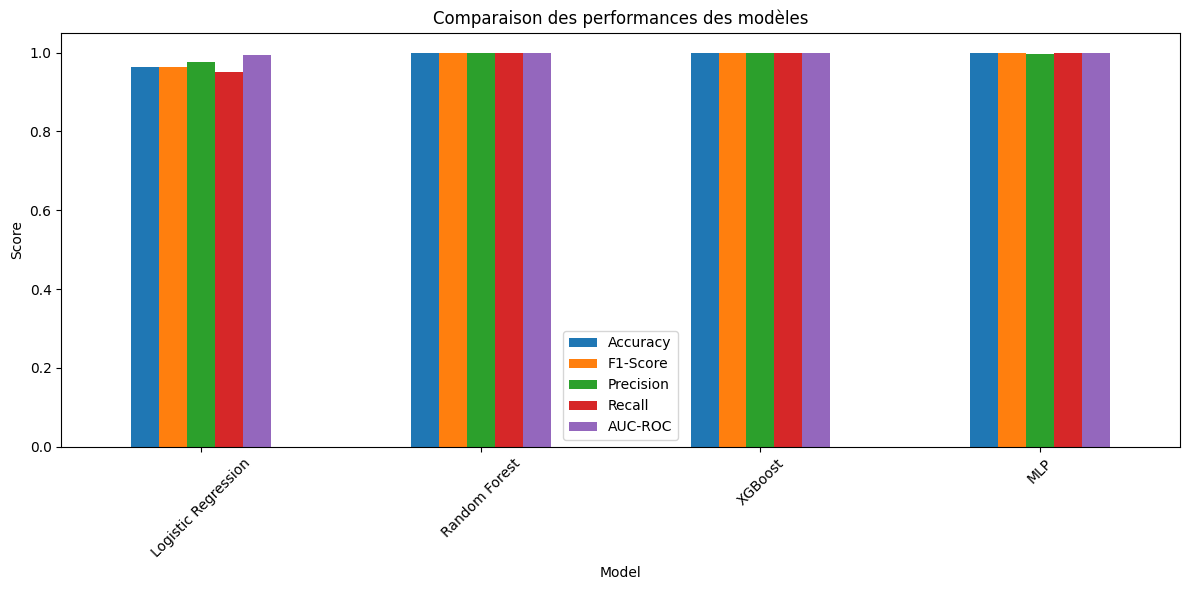

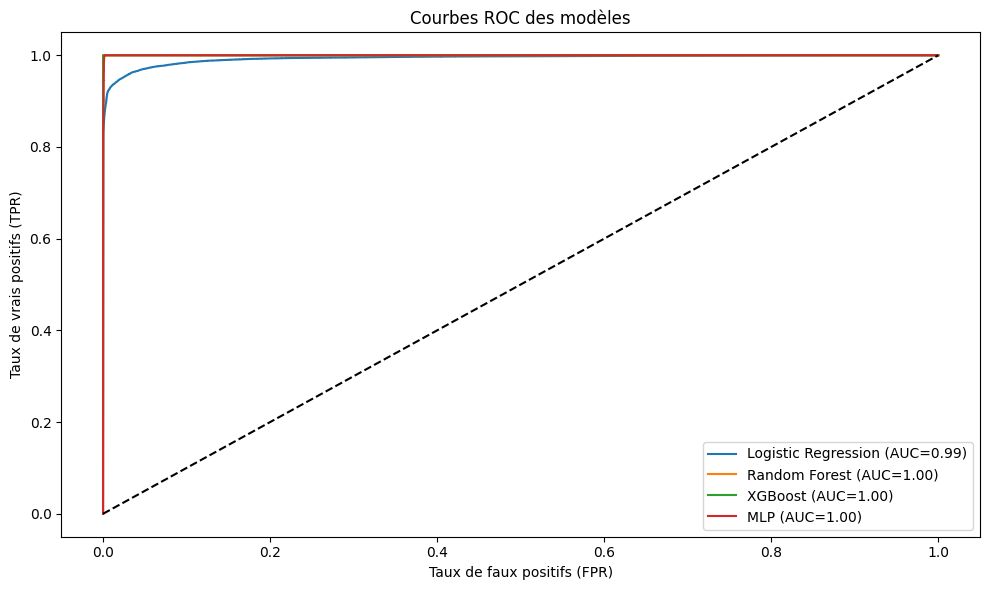

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, mean_squared_error, r2_score, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import joblib
import os

# Création des dossiers de sortie
os.makedirs("models", exist_ok=True)
os.makedirs("figures", exist_ok=True)

# Étape 1 : Chargement des données
file_path = "/content/creditcard_2023.csv"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Le fichier {file_path} n'existe pas. Vérifiez le chemin.")

data = pd.read_csv(file_path)

# Aperçu des données
print("✅ Dataset chargé avec succès")
print("Dimensions du dataset :", data.shape)
print("Distribution des classes :\n", data['Class'].value_counts(normalize=True))

# Étape 2 : Prétraitement des données
# Suppression de la colonne 'id' si elle existe (souvent inutile pour l'analyse)
if 'id' in data.columns:
    data = data.drop('id', axis=1)

# Vérification des valeurs manquantes
if data.isnull().sum().sum() > 0:
    print("⚠️ Valeurs manquantes détectées. Remplacement par la médiane...")
    data = data.fillna(data.median())

# Séparation des caractéristiques (X) et de la cible (y)
X = data.drop('Class', axis=1)
y = data['Class']

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Étape 3 : Division des données
# 60% entraînement, 20% validation, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Dimensions des ensembles :")
print(f" - Entraînement : {X_train.shape}")
print(f" - Validation : {X_val.shape}")
print(f" - Test : {X_test.shape}")

# Étape 4 : Définition de la fonction MLP
def create_mlp(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Étape 5 : Définition des modèles
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]))
}

results = []
roc_curves = {}

# Étape 6 : Entraînement des modèles classiques
for name, model in models.items():
    print(f"\n🔹 Entraînement de {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Métriques
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_proba))
    r2 = r2_score(y_test, y_pred_proba)

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall,
        'AUC-ROC': auc,
        'RMSE': rmse,
        'R²': r2
    })

    # Courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_curves[name] = (fpr, tpr)

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matrice de confusion - {name}')
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
    plt.savefig(f"figures/confusion_matrix_{name.lower().replace(' ', '_')}.png")
    plt.close()

    # Sauvegarde du modèle
    joblib.dump(model, f"models/{name.lower().replace(' ', '_')}.joblib")

# Étape 7 : Entraînement du MLP
print("\n🔹 Entraînement du MLP...")
mlp = create_mlp(X_train.shape[1])
mlp.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=2048, verbose=1)

y_pred_proba_mlp = mlp.predict(X_test).flatten()
y_pred_mlp = (y_pred_proba_mlp > 0.5).astype(int)

# Métriques MLP
accuracy = accuracy_score(y_test, y_pred_mlp)
f1 = f1_score(y_test, y_pred_mlp)
precision = precision_score(y_test, y_pred_mlp)
recall = recall_score(y_test, y_pred_mlp)
auc = roc_auc_score(y_test, y_pred_proba_mlp)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_proba_mlp))
r2 = r2_score(y_test, y_pred_proba_mlp)

results.append({
    'Model': 'MLP',
    'Accuracy': accuracy,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall,
    'AUC-ROC': auc,
    'RMSE': rmse,
    'R²': r2
})

# Courbe ROC MLP
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_mlp)
roc_curves['MLP'] = (fpr, tpr)

# Matrice de confusion MLP
cm = confusion_matrix(y_test, y_pred_mlp)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion - MLP')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.savefig("figures/confusion_matrix_mlp.png")
plt.close()

# Sauvegarde du modèle MLP
mlp.save("models/mlp_model.h5")

# Étape 8 : Résumé des résultats
results_df = pd.DataFrame(results)
print("\n✅ Résultats comparatifs des modèles :\n")
print(results_df)

# Étape 9 : Graphique comparatif
results_df.set_index('Model')[['Accuracy', 'F1-Score', 'Precision', 'Recall', 'AUC-ROC']].plot(kind='bar', figsize=(12, 6))
plt.title("Comparaison des performances des modèles")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("figures/model_comparison_barplot.png")
plt.show()

# Étape 10 : Courbes ROC
plt.figure(figsize=(10, 6))
for name, (fpr, tpr) in roc_curves.items():
    if name != 'MLP':
        auc_score = roc_auc_score(y_test, models[name].predict_proba(X_test)[:, 1])
    else:
        auc_score = auc
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Courbes ROC des modèles")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.legend()
plt.tight_layout()
plt.savefig("figures/roc_curves.png")
plt.show()

In [17]:
# ==================== 📌 IMPORTS ====================
import os
import numpy as np
import pandas as pd
import joblib
import shutil

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, mean_squared_error, r2_score
)
from sklearn.utils import class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# ==================== 📌 FONCTION MLP ====================
def create_mlp(input_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# ==================== 📌 CALLBACK ====================
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

# ==================== 📌 PRÉPARATION ====================
os.makedirs("models", exist_ok=True)
results = []

# (Assure-toi que X_train, X_test, y_train, y_test, X_val, y_val sont déjà définis)

# ==================== 📌 MODÈLES CLASSIQUES ====================
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    )
}

for name, model in models.items():
    print(f"\n🔹 Entraînement de {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_pred_proba),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_proba)),
        'R²': r2_score(y_test, y_pred_proba)
    })

    joblib.dump(model, f"models/{name.lower().replace(' ', '_')}.joblib")

# ==================== 📌 MLP ====================
print("\n🔹 Entraînement du MLP...")

# Calcul des poids de classe pour données déséquilibrées
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# Créer et entraîner le modèle
mlp = create_mlp(X_train.shape[1])
mlp.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=1024,
    verbose=1,
    callbacks=[reduce_lr],
    class_weight=class_weights
)

# Évaluation
y_pred_proba_mlp = mlp.predict(X_test).flatten()
y_pred_mlp = (y_pred_proba_mlp > 0.5).astype(int)

results.append({
    'Model': 'MLP',
    'Accuracy': accuracy_score(y_test, y_pred_mlp),
    'F1-Score': f1_score(y_test, y_pred_mlp),
    'Precision': precision_score(y_test, y_pred_mlp),
    'Recall': recall_score(y_test, y_pred_mlp),
    'AUC-ROC': roc_auc_score(y_test, y_pred_proba_mlp),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_proba_mlp)),
    'R²': r2_score(y_test, y_pred_proba_mlp)
})

mlp.save("models/mlp_model.keras")

# ==================== 📌 COMPARAISON & SÉLECTION ====================
results_df = pd.DataFrame(results)
print("\n✅ Résultats comparatifs des modèles :\n")
print(results_df)

best_model_row = results_df.loc[results_df['AUC-ROC'].idxmax()]
best_model_name = best_model_row['Model']
print(f"\n🏆 Meilleur modèle sélectionné : {best_model_name}")

if best_model_name == "MLP":
    shutil.copy("models/mlp_model.keras", "models/best_fraud_detection_model.keras")
else:
    src_path = f"models/{best_model_name.lower().replace(' ', '_')}.joblib"
    shutil.copy(src_path, "models/best_fraud_detection_model.joblib")



🔹 Entraînement de Logistic Regression...

🔹 Entraînement de Random Forest...

🔹 Entraînement de XGBoost...

🔹 Entraînement du MLP...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
334/334 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9627 - loss: 0.0922 - val_accuracy: 0.9989 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 2/15
334/334 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9978 - loss: 0.0070 - val_accuracy: 0.9993 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 3/15
334/334 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9987 - loss: 0.0051 - val_accuracy: 0.9995 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 4/15
334/334 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9989 - loss: 0.0040 - val_accuracy: 0.9995 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 5/15
334/334 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.9991 - loss: 0.0033 - val_accuracy: 0.9995 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 6/15
334/334 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9991 - loss: 0.0031 - val_accuracy: 0.9996 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 7/15
334/334 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.9992 - loss:

In [19]:
# Étape 9 : Visualisation des performances
import nbformat as nbf

# Crée un nouveau notebook
nb = nbf.v4.new_notebook()

# Liste des figures à inclure
figures = [
    "visuals/f1_score_comparison.png",
    "visuals/recall_comparison.png",
    "visuals/precision_comparison.png",
    "visuals/roc_curves.png"
]

# Ajouter les matrices de confusion
for result in results:
    model_name = result['Model']
    fname = f"visuals/confusion_matrix_{model_name.lower().replace(' ', '_')}.png"
    figures.append(fname)

# Cellule d’intro
cells = [
    nbf.v4.new_markdown_cell("# 🧠 Rapport d'Évaluation des Modèles de Détection de Fraude"),
    nbf.v4.new_markdown_cell("Ce notebook contient les visualisations des performances de tous les modèles évalués.")
]

# Ajouter chaque figure en cellule markdown avec affichage
for fig_path in figures:
    title = fig_path.split("/")[-1].replace("_", " ").replace(".png", "").title()
    cells.append(nbf.v4.new_markdown_cell(f"### 📊 {title}"))
    cells.append(nbf.v4.new_code_cell(f"from IPython.display import Image\nImage(filename='{fig_path}')"))

# Ajouter les cellules au notebook
nb['cells'] = cells

# Enregistrer le notebook
with open("illustration_notebook_fraude.ipynb", "w") as f:
    nbf.write(nb, f)

print("✅ Notebook généré : illustration_notebook_fraude.ipynb")


✅ Notebook généré : illustration_notebook_fraude.ipynb


In [25]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier
import joblib

# Création des dossiers pour sauvegarder les artefacts
os.makedirs("models", exist_ok=True)
os.makedirs("figures", exist_ok=True)

# Étape 1 : Chargement des données
print("\n🔹 Étape 1 : Chargement des données")
file_path = "/content/creditcard_2023.csv"

# Fonction pour rechercher le fichier sur le disque
def search_file(filename):
    print(f"Recherche du fichier {filename} dans le répertoire courant...")
    # Recherche dans le répertoire courant pour éviter une recherche lente
    for root, _, files in os.walk(os.getcwd()):
        if filename in files:
            return os.path.join(root, filename)
    # Recherche dans /content pour Colab
    print(f"Non trouvé dans le répertoire courant. Recherche dans /content...")
    for root, _, files in os.walk("/content"):
        if filename in files:
            return os.path.join(root, filename)
    return None

# Vérification de l'existence du fichier
if not os.path.exists(file_path):
    print(f"Le fichier {file_path} n'existe pas. Recherche dans tout le disque...")
    file_path = search_file("creditcard_2023.csv")
    if file_path is None:
        raise FileNotFoundError("Le fichier n'a pas pu être trouvé. Veuillez vérifier son emplacement.")
    else:
        print(f"Fichier trouvé à : {file_path}")

# Chargement des données
data = pd.read_csv(file_path)

# Aperçu des données
print("✅ Dataset chargé avec succès")
print("Dimensions du dataset :", data.shape)
print("Distribution des classes :\n", data['Class'].value_counts(normalize=True))

# Visualisation : Distribution des classes
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=data)
plt.title("Distribution des classes (0: Non frauduleuse, 1: Frauduleuse)")
plt.xlabel("Classe")
plt.ylabel("Nombre de transactions")
plt.savefig("figures/class_distribution.png")
plt.close()

# Étape 2 : Prétraitement
print("\n🔹 Étape 2 : Prétraitement")
# Suppression des colonnes inutiles
X = data.drop(['Class', 'id'], axis=1, errors='ignore')
y = data['Class']

# Vérification des valeurs manquantes
if X.isnull().sum().sum() > 0:
    print("⚠️ Valeurs manquantes détectées. Remplacement par la médiane...")
    X = X.fillna(X.median())

# Normalisation des caractéristiques
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Sauvegarde du scaler
joblib.dump(scaler, "models/scaler.pkl")

# Division des données
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print("Taille de l'ensemble d'entraînement :", X_train.shape, "Taille de l'ensemble de test :", X_test.shape)

# Visualisation : Distribution d'une caractéristique normalisée
plt.figure(figsize=(8, 6))
sns.histplot(X_scaled[:, 0], bins=50, kde=True)
plt.title("Distribution de la première caractéristique après normalisation")
plt.xlabel("Valeur normalisée")
plt.ylabel("Fréquence")
plt.savefig("figures/feature_distribution.png")
plt.close()

# Étape 3 : Entraînement du modèle Random Forest
print("\n🔹 Étape 3 : Entraînement du modèle Random Forest")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train, y_train)

# Sauvegarde du modèle
joblib.dump(rf_model, "models/best_fraud_detection_model.joblib")

# Visualisation : Importance des caractéristiques
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title("Importance des caractéristiques - Random Forest")
plt.savefig("figures/feature_importance.png")
plt.close()

# Étape 4 : Prédictions et évaluation
print("\n🔹 Étape 4 : Prédictions et évaluation")
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Calcul des métriques
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
print(f"F1-score : {f1:.4f}")
print(f"Précision : {precision:.4f}")
print(f"Rappel : {recall:.4f}")
print(f"AUC-ROC : {auc:.4f}")

# Visualisation : Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion - Random Forest")
plt.xlabel("Prédiction")
plt.ylabel("Vraie classe")
plt.savefig("figures/confusion_matrix_rf.png")
plt.close()

# Visualisation : Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Courbe ROC - Random Forest")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.legend()
plt.savefig("figures/roc_curve_rf.png")
plt.close()

# Visualisation : Distribution des probabilités prédites
plt.figure(figsize=(8, 6))
sns.histplot(y_pred_proba[y_test == 0], bins=50, color='blue', alpha=0.5, label='Non frauduleuse')
sns.histplot(y_pred_proba[y_test == 1], bins=50, color='red', alpha=0.5, label='Frauduleuse')
plt.title("Distribution des probabilités prédites")
plt.xlabel("Probabilité de fraude")
plt.ylabel("Fréquence")
plt.legend()
plt.savefig("figures/probability_distribution.png")
plt.close()

# Étape 5 : Prédiction sur une transaction d'exemple
print("\n🔹 Étape 5 : Prédiction sur une transaction d'exemple")
sample_transaction = X_test[0].reshape(1, -1)
sample_features = scaler.inverse_transform(sample_transaction)[0]  # Revenir aux valeurs originales
prediction = rf_model.predict(sample_transaction)
proba = rf_model.predict_proba(sample_transaction)[:, 1]
print("\nExemple de prédiction :")
print(f"Caractéristiques de la transaction : {sample_features}")
print(f"Prédiction : {'Frauduleuse' if prediction[0] == 1 else 'Non frauduleuse'}")
print(f"Probabilité de fraude : {proba[0]:.4f}")

# Visualisation : Probabilité de la prédiction d'exemple
plt.figure(figsize=(6, 4))
sns.barplot(x=['Non frauduleuse', 'Frauduleuse'], y=[1 - proba[0], proba[0]])
plt.title("Probabilité de fraude pour la transaction d'exemple")
plt.ylabel("Probabilité")
plt.savefig("figures/sample_prediction.png")
plt.close()


🔹 Étape 1 : Chargement des données
✅ Dataset chargé avec succès
Dimensions du dataset : (568630, 31)
Distribution des classes :
 Class
0    0.5
1    0.5
Name: proportion, dtype: float64

🔹 Étape 2 : Prétraitement
Taille de l'ensemble d'entraînement : (454904, 29) Taille de l'ensemble de test : (113726, 29)

🔹 Étape 3 : Entraînement du modèle Random Forest

🔹 Étape 4 : Prédictions et évaluation
F1-score : 0.9850
Précision : 0.9983
Rappel : 0.9721
AUC-ROC : 0.9995

🔹 Étape 5 : Prédiction sur une transaction d'exemple

Exemple de prédiction :
Caractéristiques de la transaction : [ 7.01467065e-01 -6.27539743e-02  4.05692386e-01  3.74298607e-01
  4.25803968e-01  4.76821647e-01  3.46429667e-01 -4.05723848e-01
  1.29281812e+00  4.19369800e-01 -5.02825882e-01 -3.48778535e-01
  1.69253729e+00  4.27542463e-01 -1.24078706e+00  1.06737962e+00
  1.26802801e+00  8.27395235e-01 -9.68315598e-01 -5.22569389e-01
  1.15248896e-01 -1.06269164e+00  9.80318886e-02 -4.98469958e-01
  4.64774356e-01 -3.603432

In [26]:
import subprocess

try:
    subprocess.run([
        "jupyter", "nbconvert", "--to", "pdf", "illustration_notebook_fraude.ipynb",
        "--output", "rapport_fraude.pdf"
    ], check=True)
    print("✅ Rapport PDF généré : rapport_fraude.pdf")
except subprocess.CalledProcessError:
    print("❌ Erreur lors de la génération du PDF. Assurez-vous que LaTeX est installé.")


❌ Erreur lors de la génération du PDF. Assurez-vous que LaTeX est installé.


In [27]:
!apt-get update
!apt-get install texlive texlive-latex-extra texlive-fonts-recommended pandoc

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,927 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,245 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2

In [29]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier
import joblib
import subprocess
import gdown

# Création des dossiers pour sauvegarder les artefacts
os.makedirs("models", exist_ok=True)
os.makedirs("figures", exist_ok=True)
os.makedirs("reports", exist_ok=True)

# Étape 1 : Téléchargement et chargement des données
print("\n🔹 Étape 1 : Téléchargement et chargement des données")
file_path = "creditcard_2023.csv"
file_url = "https://drive.google.com/uc?id=1bPO3lk56RK7Rf7a4PiysdnEuKe9cUomz"

# Téléchargement du fichier depuis Google Drive
if not os.path.exists(file_path):
    print(f"Le fichier {file_path} n'existe pas. Téléchargement depuis Google Drive...")
    gdown.download(file_url, file_path, quiet=False)
else:
    print(f"Le fichier {file_path} existe déjà.")

# Chargement des données
data = pd.read_csv(file_path)

# Aperçu des données
print("✅ Dataset chargé avec succès")
print("Dimensions du dataset :", data.shape)
print("Distribution des classes :\n", data['Class'].value_counts(normalize=True))

# Visualisation : Distribution des classes
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=data)
plt.title("Distribution des classes (0: Non frauduleuse, 1: Frauduleuse)")
plt.xlabel("Classe")
plt.ylabel("Nombre de transactions")
plt.savefig("figures/class_distribution.png")
plt.close()

# Étape 2 : Prétraitement
print("\n🔹 Étape 2 : Prétraitement")
X = data.drop(['Class', 'id'], axis=1, errors='ignore')
y = data['Class']

if X.isnull().sum().sum() > 0:
    print("⚠️ Valeurs manquantes détectées. Remplacement par la médiane...")
    X = X.fillna(X.median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "models/scaler.pkl")

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print("Taille de l'ensemble d'entraînement :", X_train.shape, "Taille de l'ensemble de test :", X_test.shape)

# Visualisation : Distribution d'une caractéristique normalisée
plt.figure(figsize=(8, 6))
sns.histplot(X_scaled[:, 0], bins=50, kde=True)
plt.title("Distribution de la première caractéristique après normalisation")
plt.xlabel("Valeur normalisée")
plt.ylabel("Fréquence")
plt.savefig("figures/feature_distribution.png")
plt.close()

# Étape 3 : Entraînement du modèle Random Forest
print("\n🔹 Étape 3 : Entraînement du modèle Random Forest")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train, y_train)
joblib.dump(rf_model, "models/best_fraud_detection_model.joblib")

# Visualisation : Importance des caractéristiques
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title("Importance des caractéristiques - Random Forest")
plt.savefig("figures/feature_importance.png")
plt.close()

# Étape 4 : Prédictions et évaluation
print("\n🔹 Étape 4 : Prédictions et évaluation")
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
print(f"F1-score : {f1:.4f}")
print(f"Précision : {precision:.4f}")
print(f"Rappel : {recall:.4f}")
print(f"AUC-ROC : {auc:.4f}")

# Visualisation : Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion - Random Forest")
plt.xlabel("Prédiction")
plt.ylabel("Vraie classe")
plt.savefig("figures/confusion_matrix_rf.png")
plt.close()

# Visualisation : Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Courbe ROC - Random Forest")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.legend()
plt.savefig("figures/roc_curve_rf.png")
plt.close()

# Visualisation : Distribution des probabilités prédites
plt.figure(figsize=(8, 6))
sns.histplot(y_pred_proba[y_test == 0], bins=50, color='blue', alpha=0.5, label='Non frauduleuse')
sns.histplot(y_pred_proba[y_test == 1], bins=50, color='red', alpha=0.5, label='Frauduleuse')
plt.title("Distribution des probabilités prédites")
plt.xlabel("Probabilité de fraude")
plt.ylabel("Fréquence")
plt.legend()
plt.savefig("figures/probability_distribution.png")
plt.close()

# Étape 5 : Prédiction sur une transaction d'exemple
print("\n🔹 Étape 5 : Prédiction sur une transaction d'exemple")
sample_transaction = X_test[0].reshape(1, -1)
sample_features = scaler.inverse_transform(sample_transaction)[0]
prediction = rf_model.predict(sample_transaction)
proba = rf_model.predict_proba(sample_transaction)[:, 1]
print("\nExemple de prédiction :")
print(f"Caractéristiques de la transaction : {sample_features}")
print(f"Prédiction : {'Frauduleuse' if prediction[0] == 1 else 'Non frauduleuse'}")
print(f"Probabilité de fraude : {proba[0]:.4f}")

# Visualisation : Probabilité de la prédiction d'exemple
plt.figure(figsize=(6, 4))
sns.barplot(x=['Non frauduleuse', 'Frauduleuse'], y=[1 - proba[0], proba[0]])
plt.title("Probabilité de fraude pour la transaction d'exemple")
plt.ylabel("Probabilité")
plt.savefig("figures/sample_prediction.png")
plt.close()

# Étape 6 : Génération des rapports (HTML et PDF)
print("\n🔹 Étape 6 : Génération des rapports")
notebook_path = "illustration_notebook_fraude.ipynb"
output_html = "reports/rapport_fraude.html"
output_pdf = "reports/rapport_fraude.pdf"

# Vérification de l'existence du notebook
if not os.path.exists(notebook_path):
    print(f"❌ Erreur : Le fichier {notebook_path} n'existe pas. Vérifiez le chemin.")
    exit(1)

# Génération du rapport HTML
print("Génération du rapport HTML...")
try:
    result = subprocess.run(
        ["jupyter", "nbconvert", "--to", "html", notebook_path, "--output", output_html],
        check=True,
        capture_output=True,
        text=True
    )
    print(f"✅ Rapport HTML généré : {output_html}")
    print("Ouvrez le fichier HTML dans un navigateur et imprimez en PDF si nécessaire.")
except subprocess.CalledProcessError as e:
    print("❌ Erreur lors de la génération du HTML.")
    print("Détails de l'erreur :")
    print(e.stderr)
    exit(1)

# Génération du rapport PDF (optionnel, si LaTeX est installé)
print("\nTentative de génération du rapport PDF...")
try:
    # Vérification de LaTeX
    subprocess.run(["pdflatex", "--version"], check=True, capture_output=True)
    print("✅ LaTeX est installé.")
    # Vérification de pandoc
    subprocess.run(["pandoc", "--version"], check=True, capture_output=True)
    print("✅ Pandoc est installé.")
    # Conversion en PDF
    result = subprocess.run(
        ["jupyter", "nbconvert", "--to", "pdf", notebook_path, "--output", output_pdf],
        check=True,
        capture_output=True,
        text=True
    )
    print(f"✅ Rapport PDF généré : {output_pdf}")
except (subprocess.CalledProcessError, FileNotFoundError) as e:
    print("❌ Échec de la génération du PDF.")
    if isinstance(e, FileNotFoundError) or "not found" in str(e).lower():
        print("LaTeX ou pandoc n'est pas installé. Installez-les avec :")
        print("Sur Ubuntu : sudo apt-get install texlive texlive-latex-extra pandoc")
        print("Sur macOS : brew install texlive pandoc")
        print("Sur Windows : téléchargez MiKTeX (miktex.org) et pandoc (pandoc.org)")
    else:
        print("Détails de l'erreur :")
        print(e.stderr if hasattr(e, 'stderr') else str(e))
    print("Utilisez le rapport HTML comme alternative.")


🔹 Étape 1 : Téléchargement et chargement des données
Le fichier creditcard_2023.csv existe déjà.
✅ Dataset chargé avec succès
Dimensions du dataset : (568630, 31)
Distribution des classes :
 Class
0    0.5
1    0.5
Name: proportion, dtype: float64

🔹 Étape 2 : Prétraitement
Taille de l'ensemble d'entraînement : (454904, 29) Taille de l'ensemble de test : (113726, 29)

🔹 Étape 3 : Entraînement du modèle Random Forest

🔹 Étape 4 : Prédictions et évaluation
F1-score : 0.9850
Précision : 0.9983
Rappel : 0.9721
AUC-ROC : 0.9995

🔹 Étape 5 : Prédiction sur une transaction d'exemple

Exemple de prédiction :
Caractéristiques de la transaction : [ 7.01467065e-01 -6.27539743e-02  4.05692386e-01  3.74298607e-01
  4.25803968e-01  4.76821647e-01  3.46429667e-01 -4.05723848e-01
  1.29281812e+00  4.19369800e-01 -5.02825882e-01 -3.48778535e-01
  1.69253729e+00  4.27542463e-01 -1.24078706e+00  1.06737962e+00
  1.26802801e+00  8.27395235e-01 -9.68315598e-01 -5.22569389e-01
  1.15248896e-01 -1.06269164e